# Face Recognition 
Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem.
The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person.

# Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\vinit\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

We are using a pretrained model as developing one from scratch is not feasible - we need a ton of data to do that 

# Compile the model

In [3]:
from fr_utils import *
from inception_blocks_v2 import *
#The pretrained model use Inception architecture takes 96x96 RBG images as input and outputs a 128-dimentional encoding.
#this uses channel-first convention so we need to tell Keras that.
K.set_image_data_format('channels_first')
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Triplet_loss formula

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Calculate the triplet loss according to the FaceNet paper
    
    Args:
      anchor: the embeddings for the anchor images.
      positive: the embeddings for the positive images.
      negative: the embeddings for the negative images.
  
    Returns:
      the triplet loss according to the FaceNet paper as a float tensor.
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist ,neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.maximum(basic_loss, 0.0)

    return loss

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

# Build a custom face recognition dataset

https://www.pyimagesearch.com/2018/06/11/how-to-build-a-custom-face-recognition-dataset/
    
Create a diverse set of images representative of that particular person’s face.

In [6]:
!pip install imutils

You are using pip version 9.0.2, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
from imutils.video import VideoStream
import imutils
import time
import cv2
import os

####  Define Face detector

OpenCV ships out-of-the-box with a more accurate face detector (as compared to OpenCV’s Haar cascades).

The more accurate OpenCV face detector is deep learning based, and in particular, utilizes the Single Shot Detector (SSD) framework with ResNet as the base network.

In [11]:
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')

[INFO] loading model...


#### Take pictures 

In [14]:
# initialize the video stream, allow the camera sensor to warm up,
# and initialize the total number of example faces written to disk
# thus far
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
#Object specifying camera with index zero as the source (in general this would be your laptop’s built in camera or your desktop’s first camera detected).
# vs = VideoStream(usePiCamera=True).start()
time.sleep(2.0)
total = 0

[INFO] starting video stream...


In [ ]:
import traceback
# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    # grab the frame dimensions and convert it to a blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the detections and predictions
    net.setInput(blob)
    detections = net.forward()
    #print(detections)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):break
    # loop over the detections
    for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        #print("confidence:",confidence)
    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence
        if confidence < 0.5:continue

    # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h]) 
        (startX, startY, endX, endY) = box.astype("int")
    # draw the bounding box of the face along with the associated probability
        text = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        #cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
        #cv2.putText(frame, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"): break
# if the `k` key was pressed, write the *original* frame to disk
# so we can later process it and use it for face recognition
        #if key == ord("k"):
        if total < 10:
            try:
                face = frame[startY:startY+(endY-startY), startX:startX+(endX-startX)]
                rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                rgb = cv2.resize(rgb, (96, 96)) 
                p = 'datasets/'+'ramesh/'+"{}.png".format(str(total).zfill(5))
                cv2.imwrite(p, rgb)
                total += 1
            except Exception as e:
                print("Exception !!",e)
                print(traceback.format_exc())
        else: 
            break
        time.sleep(0.5)
# print the total faces saved and do a bit of cleanup
print("[INFO] {} face images stored".format(total))
print("[INFO] cleaning up...")

cv2.destroyAllWindows()
vs.stop()

In [13]:
vs.stop()

# Face Alignment

We want all faces across an entire dataset : 

- Be centered in the image.
- Be rotated that such the eyes lie on a horizontal line (i.e., the face is rotated such that the eyes lie along the same y-coordinates).
- Be scaled such that the size of the faces are approximately identical.

In [64]:
# load the input image and convert it from BGR to RGB
image = cv2.imread('datasets/'+'ramesh/'+'00006.png')

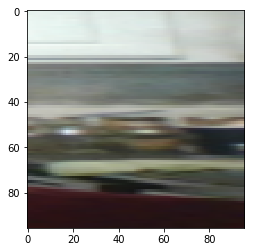

In [65]:
plt.imshow(np.array(image))

wonder why this was considered a face

Thus, face alignment can be seen as a form of “data normalization”. Just as you may normalize a set of feature vectors via zero centering or scaling to unit norm prior to training a machine learning model, it’s very common to align the faces in your dataset before training a face recognizer.

We will skip this for now 

# Create database

In [15]:
#https://stackoverflow.com/questions/18621513/python-insert-numpy-array-into-sqlite3-database

import codecs
import sqlite3
import numpy as np
import io

compressor = 'zlib'  # zlib, bz2

def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    # zlib uses similar disk size that Matlab v5 .mat files
    # bz2 compress 4 times zlib, but storing process is 20 times slower.
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    #return sqlite3.Binary(out.read().encode(compressor))  # zlib, bz2
    return sqlite3.Binary(codecs.encode(out.read(),compressor))

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    #out = io.BytesIO(out.read().decode(compressor))
    out = io.BytesIO(codecs.decode(out.read(),compressor))
    return np.load(out)

# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)


con = sqlite3.connect("coffee.sqlite", detect_types=sqlite3.PARSE_DECLTYPES)
cur = con.cursor()

In [16]:
cur.execute('''CREATE TABLE IF NOT EXISTS Encoding
    (id INTEGER, encoding array)''')

cur.execute('''CREATE TABLE IF NOT EXISTS Customer
    (id INTEGER NOT NULL, name TEXT, personality INTEGER, coffeewhen INTEGER, tastes INTEGER)''')

cur.execute('''CREATE TABLE IF NOT EXISTS History
    (datetime TEXT PRIMARY KEY, id INTEGER, blend INTEGER, type INTEGER, sweetness INTEGER, cream INTEGER, milk INTEGER, chocholate INTEGER, topping INTEGER, rating INTEGER)''')

# Create Encoding 

In [21]:
import os
images = [image for image in os.listdir('datasets/'+'vinitha/') if image.endswith(('.jpeg', '.png'))]

In [22]:
import re
with open('id.txt', 'r+') as f:
    text = f.read()
    new_id = int(text) + 1
    text = re.sub(text, str(new_id), text)
    f.seek(0)
    f.write(text)
    f.truncate()

In [23]:
images

['00000.png',
 '00001.png',
 '00002.png',
 '00003.png',
 '00004.png',
 '00005.png',
 '00006.png',
 '00007.png',
 '00008.png',
 '00009.png']

In [24]:
for image in images: 
    encoding = img_to_encoding('datasets/'+'vinitha/'+image, FRmodel)
    cur.execute("insert into Encoding (id, encoding) values (?,?)", (new_id,encoding))

In [25]:
con.commit()

In [54]:
cur1 = con.cursor()
cur1.execute('SELECT * FROM Encoding')
count = 0
for row in cur1:
    print(row)
    count = count + 1

(4, array([[ 0.15133452,  0.01758699, -0.01629576,  0.02334049,  0.06652068,
         0.152939  ,  0.16417569,  0.02444659, -0.08322641, -0.10360485,
         0.06392024,  0.0679393 ,  0.14132431, -0.05814672, -0.01908343,
        -0.07927726,  0.02079583,  0.01236501, -0.15250322,  0.17512363,
         0.14886118, -0.04419495, -0.03947591,  0.1871991 , -0.0446673 ,
        -0.1327988 , -0.15276118, -0.11996102,  0.02491185,  0.15696236,
        -0.04155017,  0.02384861, -0.08769102,  0.14439635, -0.00944295,
        -0.01722821, -0.01801576,  0.09022631, -0.07977448, -0.06789795,
         0.02138738, -0.03262819, -0.0116017 , -0.00781083, -0.07158277,
        -0.04445732,  0.07916531,  0.01760665, -0.14376989,  0.10334939,
        -0.01441013, -0.08264391, -0.01807774,  0.03383616,  0.11094378,
         0.0104987 , -0.14439423,  0.17469445, -0.07103664, -0.06804143,
        -0.06181538,  0.07185877,  0.14697298, -0.19058445,  0.0225687 ,
         0.00618568,  0.0358239 , -0.04697379, 

In [20]:
encoding

array([[ 0.12152881,  0.09188916, -0.00754821, -0.02073791,  0.17012234,
         0.19851905,  0.15284021,  0.00243269, -0.1408955 , -0.00539372,
         0.03108046,  0.05258132,  0.12451024, -0.03498418,  0.06254941,
        -0.07347922,  0.0398827 ,  0.04971173, -0.11482266,  0.16455308,
         0.08805485, -0.01015937, -0.00895543,  0.034611  , -0.03186841,
        -0.0906215 , -0.20718402, -0.08726931,  0.08911348,  0.09539324,
        -0.05858948,  0.06634507, -0.09875456,  0.0835895 ,  0.04504749,
         0.01103058,  0.01626561,  0.09164783, -0.01051814, -0.10464758,
         0.09518647, -0.00328427, -0.01511312, -0.0535416 , -0.20597595,
         0.0482948 ,  0.0869605 ,  0.04378006, -0.18170606,  0.02393293,
        -0.04551375, -0.02612478, -0.0692684 ,  0.02282738,  0.06807111,
        -0.01767778, -0.10949825,  0.1353339 , -0.13040979, -0.03781217,
        -0.09157162,  0.06606552,  0.15604332, -0.20463607,  0.12120697,
         0.07079078,  0.01567128,  0.04338055, -0.1

# Who is it?

In [13]:
cur.execute("insert into Customer (id, name, personality, coffeewhen, tastes) values (?,'Vinitha',1,1,1)", (new_id,))

In [55]:
cur.execute("insert into Customer (id, name, personality, coffeewhen, tastes) values (?,'Ramesh',1,1,1)", (new_id,))

In [56]:
cur1 = con.cursor()
cur1.execute('SELECT * FROM Customer')

In [57]:
for row in cur1: print(row)

(4, 'Vinitha', 1, 1, 1)
(5, 'Ramesh', 1, 1, 1)


In [23]:
def who_is_it(visitor_encoding):
     # Initialize "min_dist" to a large value, say 100 (≈1 line)
    name = ''
    min_dist = 100
    cur1 = con.cursor()
    cur1.execute('SELECT * FROM Encoding')
    for row in cur1:
       
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. 
        dist = np.linalg.norm(encoding - row[1])
        print(dist)
        
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. 
        if dist < min_dist:
            min_dist = dist
            name_id = row[0]
            cur2 = con.cursor()
            cur2.execute('SELECT name FROM Customer WHERE id = ? LIMIT 1', (row[0], ))
            name  = cur2.fetchone()[0]

    if min_dist > 0.7:
        print("Not in the database.")
        name = ''
    return name

In [59]:
#Test who is it function
#vinitha
cur3 = con.cursor()
cur3.execute('SELECT encoding FROM Encoding WHERE id = ? LIMIT 1', (4, ))
encoding  = cur3.fetchone()[0]
who_is_it(encoding)

'Vinitha'

In [26]:
unknown = np.random.randn(1,128)
#who_is_it(unknown)
min_dist = 100
cur1 = con.cursor()
cur1.execute('SELECT * FROM Encoding')
for row in cur1:
       # Compute L2 distance between the target "encoding" and the current "emb" from the database. 
    print(row)
    dist = np.linalg.norm(encoding - row[1])
    print(dist)
        
    # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. 
    if dist < min_dist:
        min_dist = dist
        name_id = row[0]
        cur2 = con.cursor()
        cur2.execute('SELECT name FROM Customer WHERE id = ? LIMIT 1', (row[0], ))
        name  = cur2.fetchone()[0]
        print(name)

(6, array([[ 0.15894651, -0.0233596 , -0.06264205, -0.04629132,  0.18332629,
         0.19699748,  0.16236542,  0.04842134, -0.10791622, -0.1000511 ,
        -0.02174216,  0.06960098,  0.14443672,  0.00469611,  0.04713164,
        -0.12399424,  0.0566527 , -0.01850134, -0.14098547,  0.18331176,
         0.06055925,  0.0217477 ,  0.06205758,  0.08051381, -0.07941387,
        -0.14193387, -0.16154131, -0.08434856,  0.00660645,  0.04122876,
        -0.02267731,  0.02934863, -0.11773886,  0.1338885 , -0.0201929 ,
         0.02470309,  0.01219636,  0.09414459, -0.10808303, -0.05451531,
         0.10296374,  0.05163701, -0.05377961, -0.02975401, -0.22241008,
         0.00095058,  0.0154334 ,  0.09375688, -0.04592092,  0.13261129,
        -0.05101121, -0.09193686, -0.05035111,  0.04579085,  0.08362823,
        -0.04264473, -0.08106567,  0.18186289, -0.05624176, -0.04281005,
        -0.07833765,  0.12747371,  0.12521404, -0.20723663,  0.05291893,
        -0.03481057,  0.04532803,  0.06210036, 

TypeError: 'NoneType' object is not subscriptable

In [60]:
#vinitha
cur3 = con.cursor()
cur3.execute('SELECT encoding FROM Encoding WHERE id = ? LIMIT 1', (5, ))
encoding  = cur3.fetchone()[0]
who_is_it(encoding)

'Ramesh'

In [37]:
# initialize the video stream, allow the camera sensor to warm up,
# and initialize the total number of example faces written to disk
# thus far
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
#Object specifying camera with index zero as the source (in general this would be your laptop’s built in camera or your desktop’s first camera detected).
# vs = VideoStream(usePiCamera=True).start()
time.sleep(2.0)
total = 0

[INFO] starting video stream...


In [ ]:
import traceback
found = False
name = ''
# loop over the frames from the video stream

while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    # grab the frame dimensions and convert it to a blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the detections and predictions
    net.setInput(blob)
    detections = net.forward()
    print(detections)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):break
    # loop over the detections
    for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        print("confidence:",confidence)
    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence
        if confidence < 0.5:continue

    # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h]) 
        (startX, startY, endX, endY) = box.astype("int")
    # draw the bounding box of the face along with the associated probability
        text = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        #cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
        #cv2.putText(frame, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"): break
# if the `k` key was pressed, write the *original* frame to disk
# so we can later process it and use it for face recognition
        #if key == ord("k"):
        if (total < 10 or not found):
            try:
                face = frame[startY:startY+(endY-startY), startX:startX+(endX-startX)]
                rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                rgb = cv2.resize(rgb, (96, 96)) 
                p = 'datasets/'+'visitor/'+"{}.png".format(str(total).zfill(5))
                cv2.imwrite(p, rgb)
                visitor_en = img_to_encoding(p, FRmodel)
                name = who_is_it(visitor_en)
                if name:
                    print("Found : ",name)
                    break    
                total += 1
            except Exception as e:
                print("Exception !!",e)
                print(traceback.format_exc())
        else: 
            print("Do not recognize this face")
            break
        #time.sleep(1.0)
# print the total faces saved and do a bit of cleanup
print("[INFO] {} face images stored".format(total))
print("[INFO] cleaning up...")

cv2.destroyAllWindows()
vs.stop()

In [48]:
con.commit()

# References

Andrew Ng "Coursera Deep Learning Specialization"

Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). FaceNet: A Unified Embedding for Face Recognition and Clustering
    
Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). DeepFace: Closing the gap to human-level performance in face verification

The pretrained model is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.

Official FaceNet github repository: https://github.com/davidsandberg/facenet

https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/

https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78